60/60 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step
Best Threshold: 0.4165
AUC: 0.9699


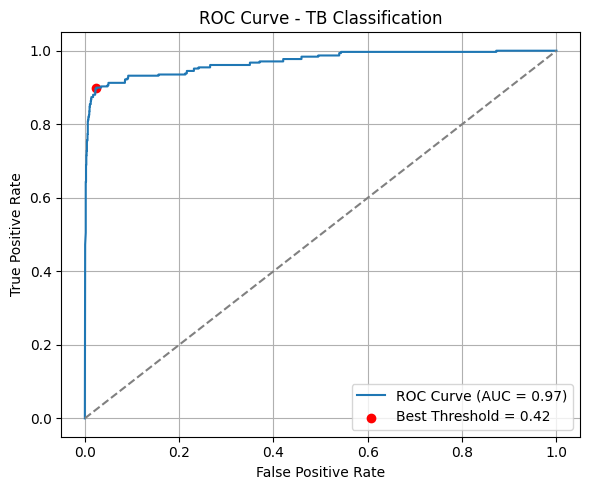

In [4]:
# Best Threshold

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# === Load CSV and image directory ===
df = pd.read_csv(r"C:\Users\Devansh\Desktop\ProjectNew\Datasets\tbx11k-simplified\data.csv")
image_dir = r"C:\Users\Devansh\Desktop\ProjectNew\Datasets\tbx11k-simplified\images"

# === CLAHE + 3-channel preprocessing ===
def preprocess_image(fname, img_size=(128, 128)):
    img_path = os.path.join(image_dir, fname)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, img_size)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
    img = img / 255.0
    return img

# === Load only validation images and labels ===
images = []
labels = []

for _, row in df.iterrows():
    if row['source'] == 'val':
        img = preprocess_image(row['fname'])
        if img is not None:
            images.append(img)
            label = 1 if row['target'] == 'tb' else 0
            labels.append(label)

X_val = np.array(images)
y_val = np.array(labels)

# === Load the trained model ===
model = load_model(r"C:\Users\Devansh\Desktop\ProjectNew\Model_7_Resnet50\model_7_Resnet50.h5")

# === Predict TB probabilities ===
y_pred_probs = model.predict(X_val)[0]  # tb_output
y_scores = y_pred_probs[:, 1]  # Score for TB class

# === ROC Curve and Best Threshold ===
fpr, tpr, thresholds = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

# Best threshold = threshold with highest TPR - FPR
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"AUC: {roc_auc:.4f}")

# === Plot ROC Curve ===
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[best_idx], tpr[best_idx], marker='o', color='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TB Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
# Use Model

import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# === Function to preprocess image (CLAHE + resize + grayscale to RGB) ===
def preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.resize(img, target_size)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = np.stack([img] * 3, axis=-1)  # Convert grayscale to RGB
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# === Load model ===
model_path = r"C:\Users\Devansh\Desktop\ProjectNew\Model_7_Resnet50\model_7_Resnet50.h5"
model = load_model(model_path)

# === Define your best threshold ===
TB_THRESHOLD = 0.4165

def predict_tb(image_path):
    try:
        img = preprocess_image(image_path)
        tb_pred, bbox_pred, severity_pred = model.predict(img)

        # TB classification using custom threshold
        tb_result = "TB" if tb_pred[0][1] > TB_THRESHOLD else "No TB"

        # Bounding box prediction
        if tb_result == "TB":
            bbox = {
                'xmin': round(float(bbox_pred[0][0]), 2),
                'ymin': round(float(bbox_pred[0][1]), 2),
                'width': round(float(bbox_pred[0][2]), 2),
                'height': round(float(bbox_pred[0][3]), 2)
            }
        else:
            bbox = "none"

        # Severity classification
        severity_classes = ["none", "latent_tb", "active_tb"]
        severity = severity_classes[np.argmax(severity_pred)]

        # === Show info ===
        print(f"Image: {os.path.basename(image_path)}")
        print(f"TB Prediction: {tb_result}")
        print(f"Bounding Box: {bbox}")
        print(f"Severity: {severity}")

        # === Load original image and draw box ===
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if bbox != "none":
            xmin = int(bbox['xmin'])
            ymin = int(bbox['ymin'])
            xmax = xmin + int(bbox['width'])
            ymax = ymin + int(bbox['height'])

            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis(False)
        plt.title('Prediction Result')
        plt.show()

    except Exception as e:
        print("Error:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
Image: kechuppieyyyyy.png
TB Prediction: No TB
Bounding Box: none
Severity: none


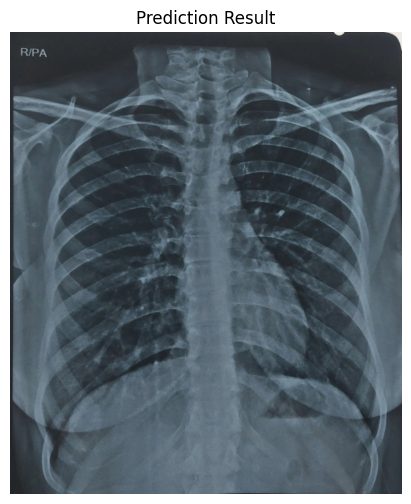

In [4]:
# === Example Usage ===
image_path = r"C:\Users\Devansh\Desktop\kechuppieyyyyy.png" # <-- Replace with actual path
predict_tb(image_path)

60/60 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step

=== TB Classification ===
Accuracy: 0.9633315872184389
Precision: 0.8769716088328076
Recall: 0.8996763754045307
F1 Score: 0.8881789137380192

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1600
           1       0.88      0.90      0.89       309

    accuracy                           0.96      1909
   macro avg       0.93      0.94      0.93      1909
weighted avg       0.96      0.96      0.96      1909



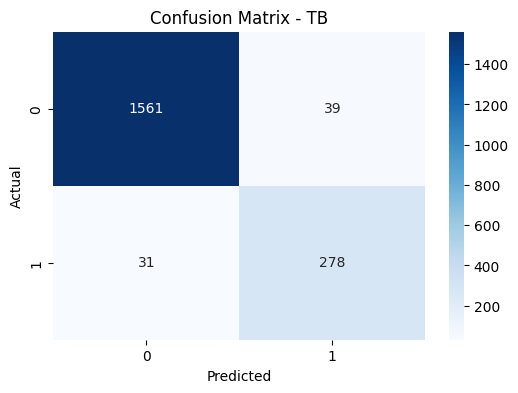


=== Bounding Box Regression ===
MSE: 1286.8791243470748

=== Severity Classification ===
Accuracy: 0.9350445259298061
Precision: 0.9122941745877557
Recall: 0.9350445259298061
F1 Score: 0.922423594933947

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1600
           1       0.00      0.00      0.00        61
           2       0.71      0.89      0.79       248

    accuracy                           0.94      1909
   macro avg       0.56      0.62      0.59      1909
weighted avg       0.91      0.94      0.92      1909



C:\Users\Devansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Devansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Devansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

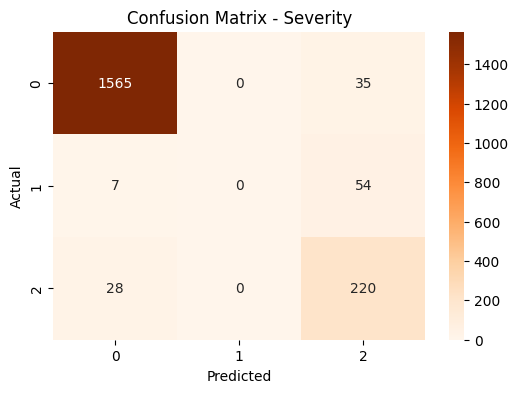

In [9]:
# Full dataset performance of the model with the new threshold 

import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, mean_squared_error
)
import matplotlib.pyplot as plt
import seaborn as sns

# === Paths & Threshold ===
csv_path = r"C:\Users\Devansh\Desktop\ProjectNew\Datasets\tbx11k-simplified\data.csv"
image_dir = r"C:\Users\Devansh\Desktop\ProjectNew\Datasets\tbx11k-simplified\images"
model_path = r"C:\Users\Devansh\Desktop\ProjectNew\Model_7_Resnet50\model_7_Resnet50.h5"
threshold = 0.4165

# === Load CSV ===
df = pd.read_csv(csv_path)

# === Preprocessing function (CLAHE + normalization + 3 channels) ===
def load_image(fname, img_size=(128, 128)):
    path = os.path.join(image_dir, fname)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, img_size)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = np.stack([img] * 3, axis=-1)
    img = img / 255.0
    return img

# === Load and preprocess validation set ===
images, y_tb_true, y_bbox_true, y_severity_true = [], [], [], []

for _, row in df.iterrows():
    if row['source'] == 'val':
        img = load_image(row['fname'])
        if img is None:
            continue

        images.append(img)

        # TB label
        y_tb_true.append(1 if row['target'] == 'tb' else 0)

        # BBox label
        if row['bbox'] != 'none':
            bbox = eval(row['bbox'])
            y_bbox_true.append([bbox['xmin'], bbox['ymin'], bbox['width'], bbox['height']])
        else:
            y_bbox_true.append([0, 0, 0, 0])

        # Severity label
        if row['tb_type'] == 'active_tb':
            y_severity_true.append(2)
        elif row['tb_type'] == 'latent_tb':
            y_severity_true.append(1)
        else:
            y_severity_true.append(0)

X = np.array(images)
y_tb_true = np.array(y_tb_true)
y_bbox_true = np.array(y_bbox_true)
y_severity_true = np.array(y_severity_true)

# === Load model and predict ===
model = load_model(model_path)
tb_pred_probs, bbox_preds, severity_probs = model.predict(X)

# === TB Predictions (threshold-based) ===
tb_preds = (tb_pred_probs[:, 1] >= threshold).astype(int)

# === Severity Predictions (argmax) ===
severity_preds = np.argmax(severity_probs, axis=1)

# === Metrics ===

# -- TB Classification
print("\n=== TB Classification ===")
print("Accuracy:", accuracy_score(y_tb_true, tb_preds))
print("Precision:", precision_score(y_tb_true, tb_preds))
print("Recall:", recall_score(y_tb_true, tb_preds))
print("F1 Score:", f1_score(y_tb_true, tb_preds))
print("\nClassification Report:\n", classification_report(y_tb_true, tb_preds))
cm_tb = confusion_matrix(y_tb_true, tb_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - TB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -- BBox Regression
print("\n=== Bounding Box Regression ===")
print("MSE:", mean_squared_error(y_bbox_true, bbox_preds))

# -- Severity Classification
print("\n=== Severity Classification ===")
print("Accuracy:", accuracy_score(y_severity_true, severity_preds))
print("Precision:", precision_score(y_severity_true, severity_preds, average='weighted'))
print("Recall:", recall_score(y_severity_true, severity_preds, average='weighted'))
print("F1 Score:", f1_score(y_severity_true, severity_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(y_severity_true, severity_preds))
cm_sev = confusion_matrix(y_severity_true, severity_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sev, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - Severity")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
